In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ultralytics --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.7 MB/s eta 0:00:00


In [ ]:
# ============================================
# 📌 IMPORTS
# ============================================
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from glob import glob

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# ============================================
# 📌 PATHS TO YOUR MODELS
# ============================================
model_paths = {
    "YOLOv8n": "/content/drive/MyDrive/YoloSeg_Results/bestn80.pt",
    "YOLOv8s": "/content/drive/MyDrive/YoloSeg_Results/bests50.pt",
    "YOLOv8m": "/content/drive/MyDrive/YoloSeg_Results/bestm100.pt"
}

In [ ]:
# ============================================
# 📌 DATASET PATHS
# ============================================
IMG_DIR = "/content/drive/MyDrive/SkinProblem/valid/images"
LBL_DIR = "/content/drive/MyDrive/SkinProblem/valid/labels"
NUM_CLASSES = 3
IMG_SIZE = 640

In [ ]:
# ============================================
# 📌 FUNCTION - YOLO TXT → MASK
# ============================================
def yolo_txt_to_mask(txt_file, img_shape, nc):
    h, w = img_shape
    masks = np.zeros((nc, h, w), dtype=np.uint8)
    if not os.path.exists(txt_file):
        return masks
    with open(txt_file, "r") as f:
        for line in f:
            cls, *pts = line.strip().split()
            cls = int(cls)
            pts = np.array(pts, dtype=float).reshape(-1, 2)
            pts = np.stack([pts[:,0]*w, pts[:,1]*h], axis=1).astype(np.int32)
            cv2.fillPoly(masks[cls], [pts], 1)
    return masks

In [ ]:
# ============================================
# 📌 STORAGE FOR ALL METRICS
# ============================================
results_summary = {
    "Model": [],
    "mAP50": [],
    "mAP50_95": [],
    "Precision": [],
    "Recall": [],
    "Dice": [],
    "Sensitivity": [],
    "Specificity": [],
    "ModelSize_MB": [],
    "Inference_MS": []
}

In [ ]:
# ============================================
# 📌 LOOP OVER MODELS
# ============================================
image_list = sorted(glob(os.path.join(IMG_DIR, "*.jpg")))

for model_name, path in model_paths.items():

    print(f"\n============================")
    print(f"Evaluating {model_name}")
    print("============================\n")

    model = YOLO(path)
    val_metrics = model.val(data="/content/drive/MyDrive/SkinProblem/data.yaml")

    # YOLO metrics
    mAP50 = float(val_metrics.box.map50)
    mAP50_95 = float(val_metrics.box.map)
    precision = float(val_metrics.box.mp)
    recall = float(val_metrics.box.mr)
    inference_ms = float(val_metrics.speed['inference'])

    # Model size
    model_size = os.path.getsize(path) / (1024 * 1024)

    # ----------------------------------------
    # SEGMENTATION UNION MASK METRICS
    # ----------------------------------------
    tp = fp = fn = tn = 0

    for img_path in image_list:
        img = cv2.imread(img_path)
        h, w = img.shape[:2]

        base = os.path.splitext(os.path.basename(img_path))[0]
        label_file = os.path.join(LBL_DIR, base + ".txt")

        # ground truth mask
        gt_masks = yolo_txt_to_mask(label_file, (h, w), NUM_CLASSES)
        gt_union = np.clip(gt_masks.sum(axis=0), 0, 1)

        # prediction
        pred_out = model.predict(source=img, imgsz=IMG_SIZE, verbose=False)

        pred_mask = np.zeros((h, w), dtype=np.uint8)
        if pred_out[0].masks is not None:
            for seg in pred_out[0].masks.data.cpu().numpy():
                seg_res = cv2.resize(seg, (w, h), interpolation=cv2.INTER_NEAREST)
                pred_mask |= (seg_res > 0.5).astype(np.uint8)

        # flatten
        gt_flat = gt_union.flatten().astype(bool)
        pred_flat = pred_mask.flatten().astype(bool)

        tp += np.logical_and(gt_flat, pred_flat).sum()
        fp += np.logical_and(~gt_flat, pred_flat).sum()
        fn += np.logical_and(gt_flat, ~pred_flat).sum()
        tn += np.logical_and(~gt_flat, ~pred_flat).sum()

    Dice = (2*tp) / (2*tp + fp + fn + 1e-7)
    Sensitivity = tp / (tp + fn + 1e-7)
    Specificity = tn / (tn + fp + 1e-7)

    # Store metrics
    results_summary["Model"].append(model_name)
    results_summary["mAP50"].append(mAP50)
    results_summary["mAP50_95"].append(mAP50_95)
    results_summary["Precision"].append(precision)
    results_summary["Recall"].append(recall)
    results_summary["Dice"].append(Dice)
    results_summary["Sensitivity"].append(Sensitivity)
    results_summary["Specificity"].append(Specificity)
    results_summary["ModelSize_MB"].append(model_size)
    results_summary["Inference_MS"].append(inference_ms)


Evaluating YOLOv8n

Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-seg summary (fused): 85 layers, 3,258,649 parameters, 0 gradients, 11.3 GFLOPs
val: Fast image access ✅ (ping: 0.5±0.2 ms, read: 28.5±9.9 MB/s, size: 49.4 KB)
val: Scanning /content/drive/MyDrive/SkinProblem/valid/labels.cache... 449 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 449/449 552.4Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 29/29 2.3it/s 12.7s
                   all        449       3018      0.522       0.52      0.497       0.22      0.483      0.484      0.443      0.154
                  acne        141       1277      0.478        0.3      0.323      0.117      0.477      0.298      0.327      0.118
           dark circle        123        211      0.591      0.839       0.76      0.358      0.589      0.834      0.748      0.278
       

In [ ]:
# ============================================
# 📌 CONVERT TO NUMPY
# ============================================
models = results_summary["Model"]
mAP50 = results_summary["mAP50"]
mAP50_95 = results_summary["mAP50_95"]
precision = results_summary["Precision"]
recall = results_summary["Recall"]
dice = results_summary["Dice"]
sensitivity = results_summary["Sensitivity"]
specificity = results_summary["Specificity"]
model_size = results_summary["ModelSize_MB"]
inference_ms = results_summary["Inference_MS"]

In [ ]:
# ============================================
# 📌 PLOTTING FUNCTION
# ============================================
def bar_plot(title, ylabel, metric):
    plt.figure(figsize=(8,5))
    plt.bar(models, metric)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()

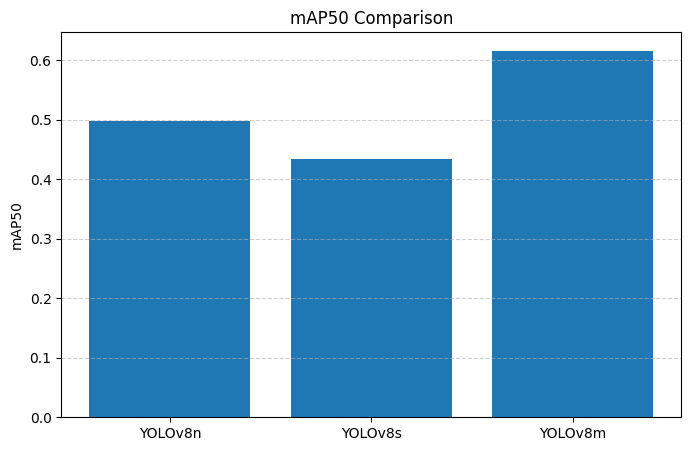

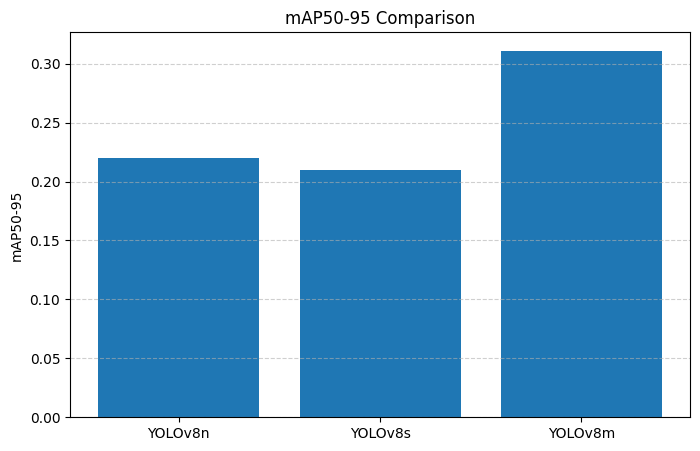

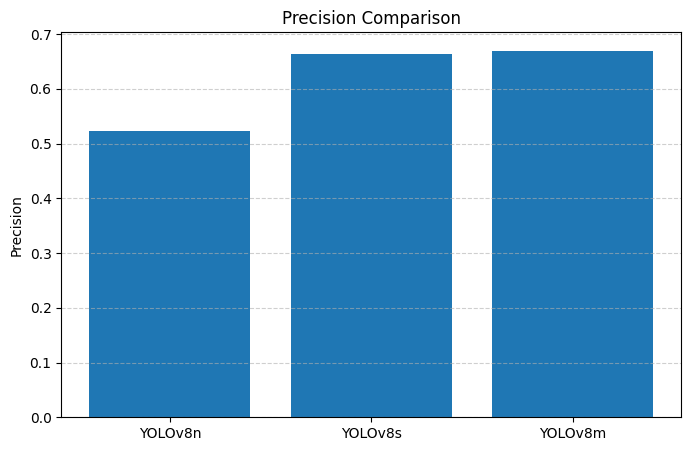

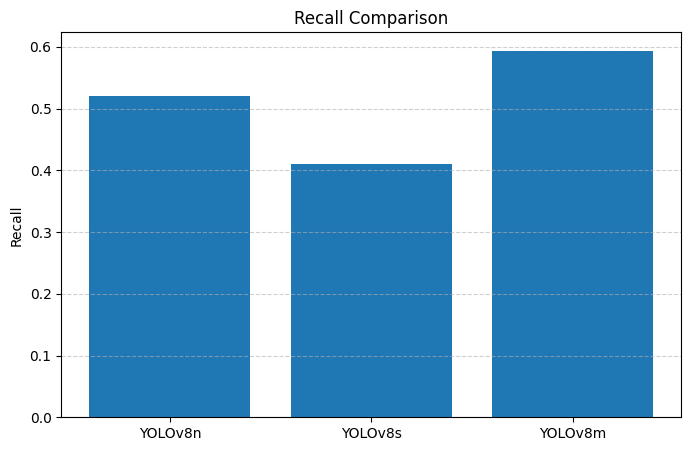

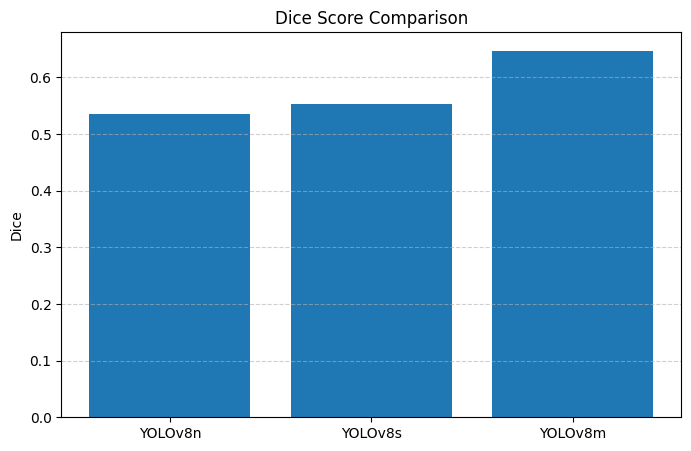

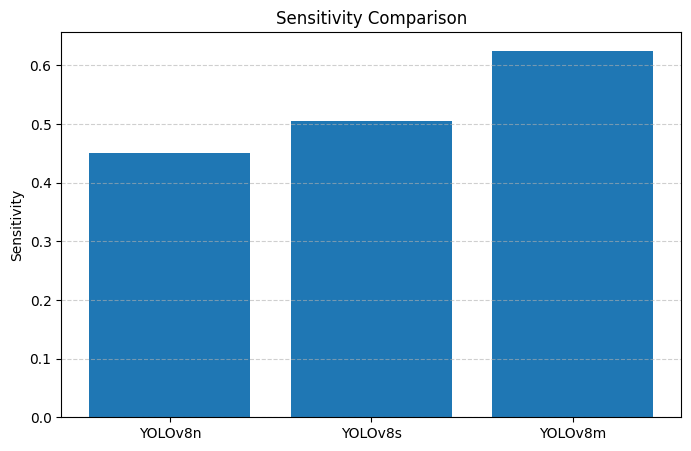

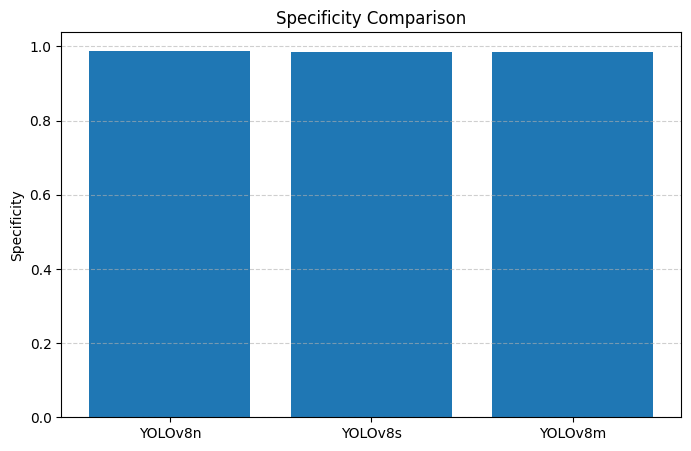

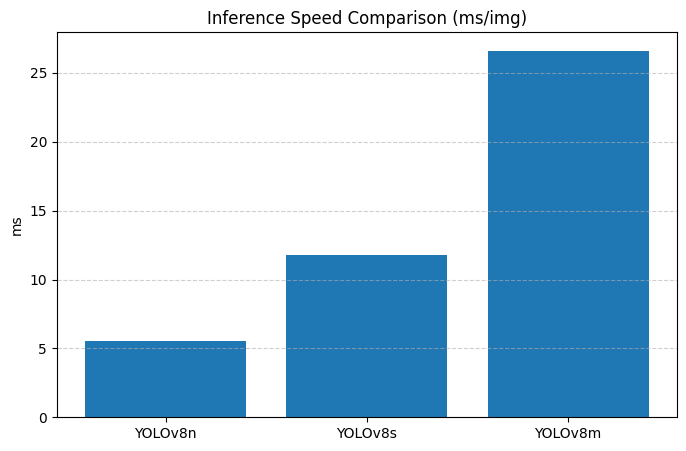

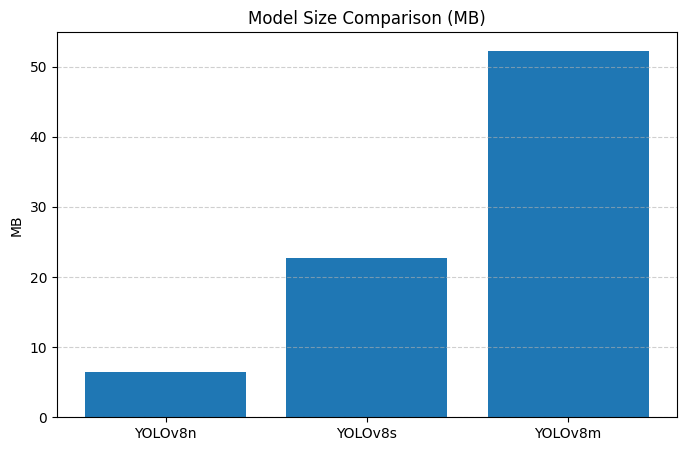

In [ ]:
# ============================================
# 📌 GENERATE ALL PLOTS
# ============================================

bar_plot("mAP50 Comparison", "mAP50", mAP50)
bar_plot("mAP50-95 Comparison", "mAP50-95", mAP50_95)
bar_plot("Precision Comparison", "Precision", precision)
bar_plot("Recall Comparison", "Recall", recall)
bar_plot("Dice Score Comparison", "Dice", dice)
bar_plot("Sensitivity Comparison", "Sensitivity", sensitivity)
bar_plot("Specificity Comparison", "Specificity", specificity)
bar_plot("Inference Speed Comparison (ms/img)", "ms", inference_ms)
bar_plot("Model Size Comparison (MB)", "MB", model_size)

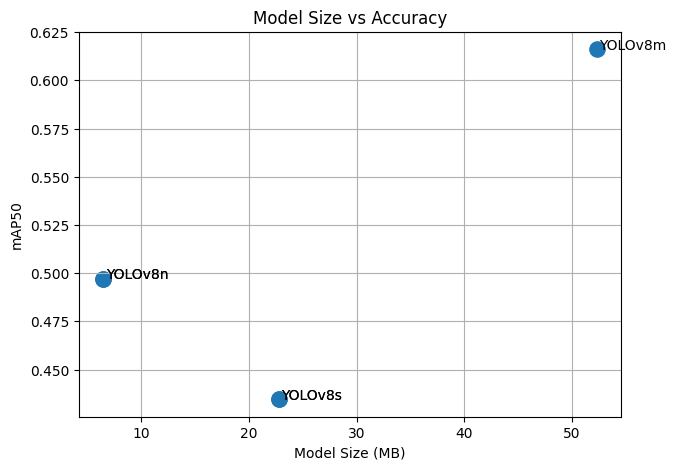

In [ ]:
# ============================================
# 📌 SCATTER PLOT: Model Size vs Accuracy
# ============================================
plt.figure(figsize=(7,5))
plt.scatter(model_size, mAP50, s=120)
for i in range(len(models)):
    plt.text(model_size[i]+0.2, mAP50[i], models[i])
plt.xlabel("Model Size (MB)")
plt.ylabel("mAP50")
plt.title("Model Size vs Accuracy")
plt.grid(True)
plt.show()
